In [1]:
import tensorflow as tf
import numpy as np
import math
from censai import PhysicalModel, RIMUnet, RayTracer
from censai.models import UnetModel
from censai.data.lenses_tng import decode_train, decode_physical_model_info, preprocess
from censai.utils import nullwriter, rim_residual_plot as residual_plot, plot_to_image
from censai.definitions import DTYPE
import os, glob, time, json
from datetime import datetime

RIM_HPARAMS = [
    "adam",
    "steps",
    "kappalog",
    "kappa_normalize",
    "kappa_init",
    "source_init"
]
SOURCE_MODEL_HPARAMS = [
    "filters",
    "filter_scaling",
    "kernel_size",
    "layers",
    "block_conv_layers",
    "strides",
    "bottleneck_kernel_size",
    "bottleneck_filters",
    "resampling_kernel_size",
    "gru_kernel_size",
    "upsampling_interpolation",
    "kernel_l2_amp",
    "bias_l2_amp",
    "kernel_l1_amp",
    "bias_l1_amp",
    "activation",
    "alpha",
    "initializer",
    "batch_norm",
    "dropout_rate",
    "input_kernel_size"
]
KAPPA_MODEL_HPARAMS = SOURCE_MODEL_HPARAMS

In [2]:
# import tensorflow as tf
# import numpy as np
# import tensorflow_addons as tfa
# from censai.definitions import DTYPE


# class PhysicalModel:
#     """
#     Physical model to be passed to RIM class at instantiation
#     """
#     def __init__(
#             self,
#             pixels,            # 512
#             psf_sigma=0.06,    # gaussian PSF
#             src_pixels=None,   # 128 for cosmos
#             kappa_pixels=None,
#             image_fov=7.68,
#             src_fov=3.0,
#             kappa_fov=7.68,
#             method="conv2d",
#             noise_rms=1,
#             raytracer=None
#     ):
#         if src_pixels is None:
#             src_pixels = pixels  # assume src has the same shape
#         if kappa_pixels is None:
#             kappa_pixels = pixels
#         self.image_fov = image_fov
#         self.psf_sigma = psf_sigma
#         self.src_fov = src_fov
#         self.pixels = pixels
#         self.src_pixels = src_pixels
#         self.kappa_pixels = kappa_pixels
#         self.kappa_fov = kappa_fov
#         self.method = method
#         self.noise_rms = noise_rms
#         self.raytracer = raytracer
#         self.set_deflection_angle_vars()
#         self.PSF = self.psf_model()
#         if kappa_pixels != pixels:
#             self.kappa_to_image_grid = self._kappa_to_image_grid
#         else:
#             self.kappa_to_image_grid = tf.identity

#     def deflection_angle(self, kappa):
#         kappa = self.kappa_to_image_grid(kappa)  # resampling to shape of image
#         if self.method == "conv2d":
#             alpha_x = tf.nn.conv2d(kappa, self.xconv_kernel, [1, 1, 1, 1], "SAME") * (self.dx_kap**2/np.pi)
#             alpha_y = tf.nn.conv2d(kappa, self.yconv_kernel, [1, 1, 1, 1], "SAME") * (self.dx_kap**2/np.pi)

#         elif self.method == "unet":
#             alpha = self.raytracer(kappa)
#             alpha_x, alpha_y = tf.split(alpha, 2, axis=-1)

#         elif self.method == "fft":
#             """
#             The convolution using the Convolution Theorem.
#             Since we use FFT to justify this approach, we must zero pad the kernel and kappa map to transform 
#             a 'circular convolution' (assumed by our use of FFT) into an an 'acyclic convolution' 
#             (sum from m=0 to infinity).
            
#             To do that, we pad our signal with N-1 trailing zeros for each dimension. N = 2*pixels+1 since 
#             our kernel has this shape.
            
#             This approach has complexity O((4*pixels)^2 * log^2(4 * pixels)), and is precise to about rms=2e-5 of the 
#             true convolution for the deflection angles.
#             """
#             # pad the kernel and compute itf fourier transform
#             xconv_kernel = tf.image.pad_to_bounding_box(self.xconv_kernel[..., 0], 0, 0, 4*self.pixels+1, 4*self.pixels+1)
#             yconv_kernel = tf.image.pad_to_bounding_box(self.yconv_kernel[..., 0], 0, 0, 4*self.pixels+1, 4*self.pixels+1)
#             x_kernel_tilde = tf.signal.fft2d(tf.cast(-xconv_kernel[..., 0], tf.complex64))
#             y_kernel_tilde = tf.signal.fft2d(tf.cast(-yconv_kernel[..., 0], tf.complex64))

#             batch_size = kappa.shape[0]
#             alpha_x = []
#             alpha_y = []
#             for i in range(batch_size):
#                 kap = tf.image.pad_to_bounding_box(kappa[i, ...],  # pad kappa one by one to save memory space
#                                                    offset_height=0,
#                                                    offset_width=0,
#                                                    target_width=4 * self.pixels + 1,
#                                                    target_height=4 * self.pixels + 1)
#                 kappa_tilde = tf.signal.fft2d(tf.cast(kap[..., 0], tf.complex64))
#                 alpha_x.append(tf.math.real(tf.signal.ifft2d(kappa_tilde * x_kernel_tilde)) * (self.dx_kap**2/np.pi))
#                 alpha_y.append(tf.math.real(tf.signal.ifft2d(kappa_tilde * y_kernel_tilde)) * (self.dx_kap**2/np.pi))
#             alpha_x = tf.stack(alpha_x, axis=0)[..., tf.newaxis]
#             alpha_x = tf.image.crop_to_bounding_box(alpha_x,
#                                                     offset_height=self.pixels,
#                                                     offset_width=self.pixels,
#                                                     target_width=self.pixels,
#                                                     target_height=self.pixels)
#             alpha_y = tf.stack(alpha_y, axis=0)[..., tf.newaxis]
#             alpha_y = tf.image.crop_to_bounding_box(alpha_y,
#                                                     offset_height=self.pixels,
#                                                     offset_width=self.pixels,
#                                                     target_width=self.pixels,
#                                                     target_height=self.pixels)
#         else:
#             raise ValueError(f"{self.method} is not in [conv2d, unet, fft]")
#         return alpha_x, alpha_y

#     def log_likelihood(self, source, kappa, y_true):
#         y_pred = self.forward(source, kappa)
# #         lam = self.lagrange_multiplier(y_true, y_pred)
# #         return 0.5 * tf.reduce_mean((y_pred - lam*y_true)**2/self.noise_rms**2, axis=(1, 2, 3))
#         return 0.5 * tf.reduce_mean((y_pred - y_true) ** 2 / self.noise_rms ** 2, axis=(1, 2, 3))

#     @staticmethod
#     def lagrange_multiplier(y_true, y_pred):
#         return tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3), keepdims=True) / tf.reduce_sum(y_true**2, axis=(1, 2, 3), keepdims=True)

#     def forward(self, source, kappa):
#         im = self.lens_source(source, kappa)
#         im = self.convolve_with_psf(im)
#         return im

#     def noisy_forward(self, source, kappa, noise_rms):
#         im = self.lens_source(source, kappa)
#         noise = tf.random.normal(im.shape, mean=0, stddev=noise_rms)
#         out = self.convolve_with_psf(im)  # convolve before adding noise, otherwise it correlates the noise
#         out = out + noise
#         return out

#     def lens_source(self, source, kappa):
#         alpha_x, alpha_y = self.deflection_angle(kappa)
#         x_src = self.ximage - alpha_x
#         y_src = self.yimage - alpha_y
#         x_src_pix, y_src_pix = self.src_coord_to_pix(x_src, y_src)
#         warp = tf.concat([x_src_pix, y_src_pix], axis=-1)
#         im = tfa.image.resampler(source, warp)  # bilinear interpolation of source on warp grid
#         return im


#     def src_coord_to_pix(self, x, y):
#         dx = self.src_fov / (self.src_pixels - 1)
#         xmin = -0.5 * self.src_fov
#         ymin = -0.5 * self.src_fov
#         i_coord = (x - xmin) / dx
#         j_coord = (y - ymin) / dx
#         return i_coord, j_coord

#     def kap_coord_to_pix(self, x, y):
#         dx = self.kappa_fov / (self.kappa_pixels - 1)
#         xmin = -0.5 * self.kappa_fov
#         ymin = -0.5 * self.kappa_fov
#         i_coord = (x - xmin) / dx
#         j_coord = (y - ymin) / dx
#         return i_coord, j_coord

#     def _kappa_to_image_grid(self, kappa):
#         batch_size = kappa.shape[0]
#         x_coord, y_coord = self.kap_coord_to_pix(self.xkappa, self.ykappa)
#         warp = tf.concat([x_coord, y_coord], axis=-1)
#         warp = tf.tile(warp, [batch_size, 1, 1, 1])  # make sure warp has same batch size has kappa
#         kappa = tfa.image.resampler(kappa, warp)
#         return kappa

#     def set_deflection_angle_vars(self):
#         self.dx_kap = self.kappa_fov / (self.pixels - 1)  # dx on image grid

#         # Convolution kernel
#         x = tf.linspace(-1, 1, 2 * self.pixels + 1) * self.kappa_fov
#         xx, yy = tf.meshgrid(x, x)
#         rho = xx**2 + yy**2
#         xconv_kernel = -self._safe_divide(xx, rho)
#         yconv_kernel = -self._safe_divide(yy, rho)
#         # reshape to [filter_height, filter_width, in_channels, out_channels]
#         self.xconv_kernel = tf.cast(xconv_kernel[..., tf.newaxis, tf.newaxis], dtype=DTYPE)
#         self.yconv_kernel = tf.cast(yconv_kernel[..., tf.newaxis, tf.newaxis], dtype=DTYPE)

#         # coordinates for image
#         x = tf.linspace(-1, 1, self.pixels) * self.image_fov / 2
#         xx, yy = tf.meshgrid(x, x)
#         # reshape for broadcast to [batch_size, pixels, pixels, 1]
#         self.ximage = tf.cast(xx[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)
#         self.yimage = tf.cast(yy[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)

#         # Coordinates for kappa
#         xkappa = tf.cast(tf.linspace(-1, 1, self.pixels), dtype=DTYPE) * self.kappa_fov / 2
#         xkappa, ykappa = tf.meshgrid(xkappa, xkappa)
#         self.xkappa = tf.cast(xkappa[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)
#         self.ykappa = tf.cast(ykappa[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)


#     @staticmethod
#     def _safe_divide(num, denominator):
#         out = np.zeros_like(num)
#         out[denominator != 0] = num[denominator != 0] / denominator[denominator != 0]
#         return out

#     def psf_model(self):
#         pixel_scale = self.image_fov / self.pixels
#         cutout_size = int(10 * self.psf_sigma / pixel_scale)
#         r_squared = self.ximage**2 + self.yimage**2
#         psf = tf.math.exp(-0.5 * r_squared / self.psf_sigma**2)
#         psf = tf.image.crop_to_bounding_box(psf,
#                                             offset_height=self.pixels//2 - cutout_size//2,
#                                             offset_width=self.pixels//2 - cutout_size//2,
#                                             target_width=cutout_size,
#                                             target_height=cutout_size)
#         psf /= tf.reduce_sum(psf)
#         psf = tf.reshape(psf, shape=[cutout_size, cutout_size, 1, 1])
#         return psf

#     def convolve_with_psf(self, images):
#         convolved_images = tf.nn.conv2d(images, self.PSF, [1, 1, 1, 1], padding="SAME")
#         return convolved_images



In [3]:
def main(args):
    files = []
    for dataset in args.datasets:
        files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
    np.random.shuffle(files)
    # Read concurrently from multiple records
    files = tf.data.Dataset.from_tensor_slices(files)
    dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=args.compression_type),
                               block_length=args.block_length, num_parallel_calls=tf.data.AUTOTUNE)
    # Read off global parameters from first example in dataset
    for physical_params in dataset.map(decode_physical_model_info):
        break
    dataset = dataset.map(decode_train).map(preprocess)
    if args.cache_file is not None:
        dataset = dataset.cache(args.cache_file)
    train_dataset = dataset.take(math.floor(args.train_split * args.total_items))\
        .shuffle(buffer_size=args.buffer_size).batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = dataset.skip(math.floor(args.train_split * args.total_items))\
        .take(math.ceil((1 - args.train_split) * args.total_items)).batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    # train_dataset = STRATEGY.experimental_distribute_dataset(train_dataset)
    # val_dataset = STRATEGY.experimental_distribute_dataset(val_dataset)
    if args.raytracer is not None:
        with open(os.path.join(args.raytracer, "ray_tracer_hparams.json"), "r") as f:
            raytracer_hparams = json.load(f)
    # with STRATEGY.scope():  # Replicate ops accross gpus
    if args.raytracer is not None:
        raytracer = RayTracer(**raytracer_hparams)
        # load last checkpoint in the checkpoint directory
        checkpoint = tf.train.Checkpoint(net=raytracer)
        manager = tf.train.CheckpointManager(checkpoint, directory=args.raytracer, max_to_keep=3)
        checkpoint.restore(manager.latest_checkpoint).expect_partial()
    else:
        raytracer = None
    phys = PhysicalModel(
        pixels=physical_params["pixels"].numpy(),
        kappa_pixels=physical_params["kappa pixels"].numpy(),
        src_pixels=physical_params["src pixels"].numpy(),
        image_fov=physical_params["image fov"].numpy(),
        kappa_fov=physical_params["kappa fov"].numpy(),
        src_fov=physical_params["source fov"].numpy(),
        method=args.forward_method,
        noise_rms=physical_params["noise rms"].numpy(),
        raytracer=raytracer,
        psf_sigma=physical_params["psf sigma"].numpy()
    )
    kappa_model = UnetModel(
        filters=args.kappa_filters,
        filter_scaling=args.kappa_filter_scaling,
        kernel_size=args.kappa_kernel_size,
        layers=args.kappa_layers,
        block_conv_layers=args.kappa_block_conv_layers,
        strides=args.kappa_strides,
        bottleneck_kernel_size=args.kappa_bottleneck_kernel_size,
        bottleneck_filters=args.kappa_bottleneck_filters,
        resampling_kernel_size=args.kappa_resampling_kernel_size,
        gru_kernel_size=args.kappa_gru_kernel_size,
        upsampling_interpolation=args.kappa_upsampling_interpolation,
        kernel_l2_amp=args.kappa_kernel_l2_amp,
        bias_l2_amp=args.kappa_bias_l2_amp,
        kernel_l1_amp=args.kappa_kernel_l1_amp,
        bias_l1_amp=args.kappa_bias_l1_amp,
        activation=args.kappa_activation,
        alpha=args.kappa_alpha,  # for leaky relu
        initializer=args.kappa_initializer,
        batch_norm=args.kappa_batch_norm,
        dropout_rate=args.kappa_dropout_rate,
        input_kernel_size=args.kappa_input_kernel_size
    )
    source_model = UnetModel(
        filters=args.source_filters,
        filter_scaling=args.source_filter_scaling,
        kernel_size=args.source_kernel_size,
        layers=args.source_layers,
        block_conv_layers=args.source_block_conv_layers,
        strides=args.source_strides,
        bottleneck_kernel_size=args.source_bottleneck_kernel_size,
        bottleneck_filters=args.source_bottleneck_filters,
        resampling_kernel_size=args.source_resampling_kernel_size,
        gru_kernel_size=args.source_gru_kernel_size,
        upsampling_interpolation=args.source_upsampling_interpolation,
        kernel_l2_amp=args.source_kernel_l2_amp,
        bias_l2_amp=args.source_bias_l2_amp,
        kernel_l1_amp=args.source_kernel_l1_amp,
        bias_l1_amp=args.source_bias_l1_amp,
        activation=args.source_activation,
        alpha=args.source_alpha,  # for leaky relu
        initializer=args.source_initializer,
        batch_norm=args.source_batch_norm,
        dropout_rate=args.source_dropout_rate,
        input_kernel_size=args.source_input_kernel_size
    )
    rim = RIMUnet(
        physical_model=phys,
        source_model=source_model,
        kappa_model=kappa_model,
        steps=args.steps,
        adam=args.adam,
        kappalog=args.kappalog,
        source_link=args.source_link,
        kappa_normalize=args.kappa_normalize,
        kappa_init=args.kappa_init,
        source_init=args.source_init
    )
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=args.initial_learning_rate,
        decay_rate=args.decay_rate,
        decay_steps=args.decay_steps,
        staircase=args.staircase
    )
    optim = tf.keras.optimizers.deserialize(
        {
            "class_name": args.optimizer,
            'config': {"learning_rate": learning_rate_schedule}
        }
    )
    # weights for time steps in the loss function
    if args.time_weights == "uniform":
        wt = tf.ones(shape=(args.steps), dtype=DTYPE) / args.steps
    elif args.time_weights == "linear":
        wt = 2 * (tf.range(args.steps, dtype=DTYPE) + 1) / args.steps / (args.steps + 1)
    elif args.time_weights == "quadratic":
        wt = 6 * (tf.range(args.steps, dtype=DTYPE) + 1) ** 2 / args.steps / (args.steps + 1) / (2 * args.steps + 1)
    else:
        raise ValueError("time_weights must be in ['uniform', 'linear', 'quadratic']")
    wt = wt[..., tf.newaxis]  # [steps, batch]

    # ==== Take care of where to write logs and stuff =================================================================
    if args.model_id.lower() != "none":
        logname = args.model_id + "_" + args.logname if args.logname is not None else args.model_id
        model_id = args.model_id
    elif args.logname is not None:
        logname = args.logname
        model_id = logname
    else:
        logname = args.logname_prefixe + "_" + datetime.now().strftime("%y-%m-%d_%H-%M-%S")
        model_id = logname
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, logname)
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        writer = tf.summary.create_file_writer(logdir)
    else:
        writer = nullwriter()
    # ===== Make sure directory and checkpoint manager are created to save model ===================================
    if args.model_dir.lower() != "none":
        checkpoints_dir = os.path.join(args.model_dir, logname)
        old_checkpoints_dir = os.path.join(args.model_dir, model_id)  # we load model from old directory in case its different
        source_checkpoints_dir = os.path.join(checkpoints_dir, "source_checkpoints")
        kappa_checkpoints_dir = os.path.join(checkpoints_dir, "kappa_checkpoints")
        if not os.path.isdir(checkpoints_dir):
            os.mkdir(checkpoints_dir)
            with open(os.path.join(checkpoints_dir, "script_params.json"), "w") as f:
                json.dump(vars(args), f, indent=4)
            os.mkdir(source_checkpoints_dir)
            with open(os.path.join(source_checkpoints_dir, "hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)["source_" + key] for key in SOURCE_MODEL_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
            os.mkdir(kappa_checkpoints_dir)
            with open(os.path.join(kappa_checkpoints_dir, "hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)["kappa_" + key] for key in KAPPA_MODEL_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
        source_ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=rim.source_model)
        source_checkpoint_manager = tf.train.CheckpointManager(source_ckpt, os.path.join(old_checkpoints_dir, "source_checkpoints"), max_to_keep=args.max_to_keep)
        kappa_ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=rim.kappa_model)
        kappa_checkpoint_manager = tf.train.CheckpointManager(kappa_ckpt, os.path.join(old_checkpoints_dir, "kappa_checkpoints"), max_to_keep=args.max_to_keep)
        save_checkpoint = True
        # ======= Load model if model_id is provided ===============================================================
        if args.model_id.lower() != "none":
            kappa_checkpoint_manager.checkpoint.restore(kappa_checkpoint_manager.latest_checkpoint)
            source_checkpoint_manager.checkpoint.restore(source_checkpoint_manager.latest_checkpoint)
        if old_checkpoints_dir != checkpoints_dir:  # save progress in another directory
            source_checkpoint_manager = tf.train.CheckpointManager(source_ckpt, source_checkpoints_dir, max_to_keep=args.max_to_keep)
            kappa_checkpoint_manager = tf.train.CheckpointManager(kappa_ckpt, kappa_checkpoints_dir, max_to_keep=args.max_to_keep)
    else:
        save_checkpoint = False
    # =================================================================================================================

    def train_step(X, source, kappa):
        with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:
            tape.watch(rim.source_model.trainable_variables)
            tape.watch(rim.kappa_model.trainable_variables)
            source_series, kappa_series, chi_squared = rim.call(X, outer_tape=tape)
            # mean over image residuals
            source_cost = tf.reduce_mean(tf.square(source_series - rim.source_inverse_link(source)), axis=(2, 3, 4))
            kappa_cost = tf.reduce_mean(tf.square(kappa_series - rim.kappa_inverse_link(kappa)), axis=(2, 3, 4))
            # weighted mean over time steps
            source_cost = tf.reduce_sum(wt * source_cost, axis=0)
            kappa_cost = tf.reduce_sum(wt * kappa_cost, axis=0)
            # final cost is mean over global batch size
            cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size
        gradient1 = tape.gradient(cost, rim.source_model.trainable_variables)
        gradient2 = tape.gradient(cost, rim.kappa_model.trainable_variables)
        if args.clipping:
            gradient1 = [tf.clip_by_value(grad, -10, 10) for grad in gradient1]
            gradient2 = [tf.clip_by_value(grad, -10, 10) for grad in gradient2]
        optim.apply_gradients(zip(gradient1, rim.source_model.trainable_variables))
        optim.apply_gradients(zip(gradient2, rim.kappa_model.trainable_variables))
        chi_squared = tf.reduce_sum(chi_squared[-1]) / args.batch_size
        source_cost = tf.reduce_sum(source_cost) / args.batch_size
        kappa_cost = tf.reduce_sum(kappa_cost) / args.batch_size
        return cost, chi_squared, source_cost, kappa_cost

    def kappa_train_step(X, source, kappa):
        with tf.GradientTape() as tape:
            tape.watch(rim.kappa_model.trainable_variables)
            kappa_series, chi_squared = rim.call_with_source(X, source, outer_tape=tape)
            # mean over image residuals
            kappa_cost = tf.reduce_mean(tf.square(kappa_series - rim.kappa_inverse_link(kappa)), axis=(2, 3, 4))
            # weighted mean over time steps
            kappa_cost = tf.reduce_sum(wt * kappa_cost, axis=0)
            # final cost is mean over global batch size
            cost = tf.reduce_sum(kappa_cost) / args.batch_size
        gradient = tape.gradient(cost, rim.kappa_model.trainable_variables)
        if args.clipping:
            gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
        optim.apply_gradients(zip(gradient, rim.kappa_model.trainable_variables))
        chi_squared = tf.reduce_sum(chi_squared[-1]) / args.batch_size
        kappa_cost = tf.reduce_sum(kappa_cost) / args.batch_size
        return cost, chi_squared, 0, kappa_cost

    # @tf.function
    # def distributed_train_step(dist_inputs):
    #     per_replica_losses, per_replica_chi_squared = STRATEGY.run(train_step, args=(dist_inputs,))
    #     # Replica losses are aggregated by summing them
    #     global_loss = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
    #     global_chi_squared = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_chi_squared, axis=None)
    #     return global_loss, global_chi_squared

    def test_step(X, source, kappa ):
        source_series, kappa_series, chi_squared = rim.predict(X)
        # mean over image residuals
        source_cost = tf.reduce_mean(tf.square(source_series - rim.source_inverse_link(source)), axis=(2, 3, 4))
        kappa_cost = tf.reduce_mean(tf.square(kappa_series - rim.kappa_inverse_link(kappa)), axis=(2, 3, 4))
        # weighted mean over time steps
        source_cost = tf.reduce_sum(wt * source_cost, axis=0)
        kappa_cost = tf.reduce_sum(wt * kappa_cost, axis=0)
        # final cost is mean over global batch size
        cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size
        chi_squared = tf.reduce_sum(chi_squared[-1]) / args.batch_size
        source_cost = tf.reduce_sum(source_cost) / args.batch_size
        kappa_cost = tf.reduce_sum(kappa_cost) / args.batch_size
        return cost, chi_squared, source_cost, kappa_cost

    # @tf.function
    # def distributed_test_step(dist_inputs):
    #     per_replica_losses, per_replica_chi_squared = STRATEGY.run(test_step, args=(dist_inputs,))
    #     global_loss = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
    #     global_chi_squared = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_chi_squared, axis=None)
    #     return global_loss, global_chi_squared

    # ====== Training loop ============================================================================================
    time_per_step = tf.metrics.Mean()
    epoch_loss = tf.metrics.Mean()
    val_loss = tf.metrics.Mean()
    epoch_chi_squared = tf.metrics.Mean()
    val_chi_squared = tf.metrics.Mean()
    epoch_source_loss = tf.metrics.Mean()
    val_source_loss = tf.metrics.Mean()
    epoch_kappa_loss = tf.metrics.Mean()
    val_kappa_loss = tf.metrics.Mean()
    history = {  # recorded at the end of an epoch only
        "train_cost": [],
        "train_chi_squared": [],
        "train_source_cost": [],
        "train_kappa_cost": [],
        "val_cost": [],
        "val_chi_squared": [],
        "val_kappa_cost": [],
        "val_source_cost": [],
        "learning_rate": [],
        "time_per_step": [],
        "step": [],
        "wall_time": []
    }
    best_loss = np.inf
    patience = args.patience
    step = 0
    global_start = time.time()
    estimated_time_for_epoch = 0
    out_of_time = False
    lastest_checkpoint = 1
    for epoch in range(args.epochs):
        if (time.time() - global_start) > args.max_time*3600 - estimated_time_for_epoch:
            break
        epoch_start = time.time()
        epoch_loss.reset_states()
        epoch_chi_squared.reset_states()
        epoch_kappa_loss.reset_states()
        epoch_source_loss.reset_states()
        time_per_step.reset_states()
        with writer.as_default():
            for batch, (X, source, kappa) in enumerate(train_dataset):
                start = time.time()
                if epoch < args.delay:
                    cost, chi_squared, source_cost, kappa_cost = kappa_train_step(X, source, kappa)
                else:  # train both unet together
                    cost, chi_squared, source_cost, kappa_cost = train_step(X, source, kappa)
        # ========== Summary and logs ==================================================================================
                _time = time.time() - start
                time_per_step.update_state([_time])
                epoch_loss.update_state([cost])
                epoch_chi_squared.update_state([chi_squared])
                epoch_kappa_loss.update_state([kappa_cost])
                epoch_source_loss.update_state([source_cost])
                step += 1
            # last batch we make a summary of residuals
            for res_idx in range(min(args.n_residuals, args.batch_size)):
                lens_true = X[res_idx]
                source_true = source[res_idx]
                kappa_true = kappa[res_idx]
                source_pred, kappa_pred, chi_squared = rim.predict(lens_true[None, ...])
                lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])[0]
                tf.summary.image(f"Residuals {res_idx}",
                                 plot_to_image(
                                     residual_plot(
                                         lens_true, source_true, kappa_true, lens_pred, source_pred[-1][0],
                                         kappa_pred[-1][0], chi_squared[-1][0]
                                     )), step=step)

            # ========== Validation set ===================
            val_loss.reset_states()
            val_chi_squared.reset_states()
            val_source_loss.reset_states()
            val_kappa_loss.reset_states()
            for X, source, kappa in val_dataset:
                cost, chi_squared, source_cost, kappa_cost = test_step(X, source, kappa)
                val_loss.update_state([cost])
                val_chi_squared.update_state([chi_squared])
                val_kappa_loss.update_state([kappa_cost])
                val_source_loss.update_state([source_cost])

            if args.n_residuals > 0 and math.ceil((1 - args.train_split) * args.total_items) > 0:  # validation set not empty set not empty
                lens_true = X
                source_true = source
                kappa_true = kappa
                source_pred, kappa_pred, chi_squared = rim.predict(lens_true)
                lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])
                lam = phys.lagrange_multiplier(y_true=lens_true, y_pred=lens_pred)
            for res_idx in range(min(args.n_residuals, args.batch_size, math.ceil((1 - args.train_split) * args.total_items))):
                try:
                    tf.summary.image(f"Val Residuals {res_idx}",
                                     plot_to_image(
                                         residual_plot(
                                             lam[res_idx]*lens_true[res_idx],  # rescale intensity like it is done in the likelihood
                                             source_true[res_idx],
                                             kappa_true[res_idx],
                                             lens_pred[res_idx],
                                             source_pred[-1][res_idx],
                                             kappa_pred[-1][res_idx],
                                             chi_squared[-1][res_idx]
                                         )), step=step)
                except ValueError:
                    continue
            val_cost = val_loss.result().numpy()
            train_cost = epoch_loss.result().numpy()
            val_chi_sq = val_chi_squared.result().numpy()
            train_chi_sq = epoch_chi_squared.result().numpy()
            val_kappa_cost = val_kappa_loss.result().numpy()
            train_kappa_cost = epoch_kappa_loss.result().numpy()
            val_source_cost = val_source_loss.result().numpy()
            train_source_cost = epoch_source_loss.result().numpy()
            tf.summary.scalar("Time per step", time_per_step.result(), step=step)
            tf.summary.scalar("Chi Squared", train_chi_sq, step=step)
            tf.summary.scalar("Kappa cost", train_kappa_cost, step=step)
            tf.summary.scalar("Val Kappa cost", val_kappa_cost, step=step)
            tf.summary.scalar("Source cost", train_source_cost, step=step)
            tf.summary.scalar("Val Source cost", val_source_cost, step=step)
            tf.summary.scalar("MSE", train_cost, step=step)
            tf.summary.scalar("Val MSE", val_cost, step=step)
            tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
            tf.summary.scalar("Val Chi Squared", val_chi_sq, step=step)
        print(f"epoch {epoch} | train loss {train_cost:.3e} | val loss {val_cost:.3e} "
              f"| lr {optim.lr(step).numpy():.2e} | time per step {time_per_step.result().numpy():.2e} s"
              f"| kappa cost {train_kappa_cost:.2e} | source cost {train_source_cost:.2e} | chi sq {train_chi_sq:.2e}")
        history["train_cost"].append(train_cost)
        history["val_cost"].append(val_cost)
        history["learning_rate"].append(optim.lr(step).numpy())
        history["train_chi_squared"].append(train_chi_sq)
        history["val_chi_squared"].append(val_chi_sq)
        history["train_kappa_cost"].append(train_kappa_cost)
        history["val_kappa_cost"].append(val_kappa_cost)
        history["train_source_cost"].append(train_source_cost)
        history["val_source_cost"].append(val_kappa_cost)
        history["time_per_step"].append(time_per_step.result().numpy())
        history["step"].append(step)
        history["wall_time"].append(time.time() - global_start)

        cost = train_cost if args.track_train else val_cost
        if np.isnan(cost):
            print("Training broke the Universe")
            break
        if cost < (1 - args.tolerance) * best_loss:
            best_loss = cost
            patience = args.patience
        else:
            patience -= 1
        if (time.time() - global_start) > args.max_time * 3600:
            out_of_time = True
        if save_checkpoint:
            source_checkpoint_manager.checkpoint.step.assign_add(1) # a bit of a hack
            kappa_checkpoint_manager.checkpoint.step.assign_add(1)
            if epoch % args.checkpoints == 0 or patience == 0 or epoch == args.epochs - 1 or out_of_time:
                with open(os.path.join(kappa_checkpoints_dir, "score_sheet.txt"), mode="a") as f:
                    np.savetxt(f, np.array([[lastest_checkpoint, cost]]))
                with open(os.path.join(source_checkpoints_dir, "score_sheet.txt"), mode="a") as f:
                    np.savetxt(f, np.array([[lastest_checkpoint, cost]]))
                lastest_checkpoint += 1
                source_checkpoint_manager.save()
                kappa_checkpoint_manager.save()
                print("Saved checkpoint for step {}: {}".format(int(source_checkpoint_manager.checkpoint.step),
                                                                source_checkpoint_manager.latest_checkpoint))
        if patience == 0:
            print("Reached patience")
            break
        if out_of_time:
            break
        if epoch > 0:  # First epoch is always very slow and not a good estimate of an epoch time.
            estimated_time_for_epoch = time.time() - epoch_start
    return rim, phys, train_dataset, val_dataset

In [4]:
from argparse import ArgumentParser
parser = ArgumentParser()
parser.add_argument("--model_id",               default="None",                 help="Start from this model id checkpoint. None means start from scratch")
parser.add_argument("--datasets",               required=True,  nargs="+",      help="Path to directories that contains tfrecords of dataset. Can be multiple inputs (space separated)")
parser.add_argument("--compression_type",       default=None,                   help="Compression type used to write data. Default assumes no compression.")

# RIM hyperparameters
parser.add_argument("--steps",                  default=16,     type=int,       help="Number of time steps of RIM")
parser.add_argument("--adam",                   action="store_true",            help="ADAM update for the log-likelihood gradient.")
parser.add_argument("--kappalog",               action="store_true")
parser.add_argument("--kappa_normalize",        action="store_true")
parser.add_argument("--source_link",            default="identity",             help="One of 'exp', 'source', 'relu' or 'identity' (default).")
parser.add_argument("--kappa_init",             default=1e-1,   type=float,     help="Initial value of kappa for RIM")
parser.add_argument("--source_init",            default=1e-3,   type=float,     help="Initial value of source for RIM")

# Kappa model hyperparameters
parser.add_argument("--kappa_filters",                  default=32,     type=int)
parser.add_argument("--kappa_filter_scaling",           default=1,      type=float)
parser.add_argument("--kappa_kernel_size",              default=3,      type=int)
parser.add_argument("--kappa_layers",                   default=2,      type=int)
parser.add_argument("--kappa_block_conv_layers",        default=2,      type=int)
parser.add_argument("--kappa_strides",                  default=2,      type=int)
parser.add_argument("--kappa_bottleneck_kernel_size",   default=None,   type=int)
parser.add_argument("--kappa_bottleneck_filters",       default=None,   type=int)
parser.add_argument("--kappa_resampling_kernel_size",   default=None,   type=int)
parser.add_argument("--kappa_gru_kernel_size",          default=None,   type=int)
parser.add_argument("--kappa_upsampling_interpolation", action="store_true")
parser.add_argument("--kappa_kernel_l2_amp",            default=0,      type=float)
parser.add_argument("--kappa_bias_l2_amp",              default=0,      type=float)
parser.add_argument("--kappa_kernel_l1_amp",            default=0,      type=float)
parser.add_argument("--kappa_bias_l1_amp",              default=0,      type=float)
parser.add_argument("--kappa_activation",               default="leaky_relu")
parser.add_argument("--kappa_alpha",                    default=0.1,    type=float)
parser.add_argument("--kappa_initializer",              default="glorot_normal")
parser.add_argument("--kappa_batch_norm",               action="store_true")
parser.add_argument("--kappa_dropout_rate",             default=None,   type=float)
parser.add_argument("--kappa_input_kernel_size",        default=11,      type=int)

# Source model hyperparameters
parser.add_argument("--source_filters",                  default=32,     type=int)
parser.add_argument("--source_filter_scaling",           default=1,      type=float)
parser.add_argument("--source_kernel_size",              default=3,      type=int)
parser.add_argument("--source_layers",                   default=2,      type=int)
parser.add_argument("--source_block_conv_layers",        default=2,      type=int)
parser.add_argument("--source_strides",                  default=2,      type=int)
parser.add_argument("--source_bottleneck_kernel_size",   default=None,   type=int)
parser.add_argument("--source_bottleneck_filters",       default=None,   type=int)
parser.add_argument("--source_resampling_kernel_size",   default=None,   type=int)
parser.add_argument("--source_gru_kernel_size",          default=None,   type=int)
parser.add_argument("--source_upsampling_interpolation", action="store_true")
parser.add_argument("--source_kernel_l2_amp",            default=0,      type=float)
parser.add_argument("--source_bias_l2_amp",              default=0,      type=float)
parser.add_argument("--source_kernel_l1_amp",            default=0,      type=float)
parser.add_argument("--source_bias_l1_amp",              default=0,      type=float)
parser.add_argument("--source_activation",               default="leaky_relu")
parser.add_argument("--source_alpha",                    default=0.1,    type=float)
parser.add_argument("--source_initializer",              default="glorot_normal")
parser.add_argument("--source_batch_norm",               action="store_true")
parser.add_argument("--source_dropout_rate",             default=None,   type=float)
parser.add_argument("--source_input_kernel_size",        default=11,      type=int)

# Physical model hyperparameter
parser.add_argument("--forward_method",         default="conv2d",               help="One of ['conv2d', 'fft', 'unet']. If the option 'unet' is chosen, the parameter "
                                                                                     "'--raytracer' must be provided and point to model checkpoint directory.")
parser.add_argument("--raytracer",              default=None,                   help="Path to raytracer checkpoint dir if method 'unet' is used.")

# Training set params
parser.add_argument("-b", "--batch_size",       default=1,      type=int,       help="Number of images in a batch. ")
parser.add_argument("--train_split",            default=0.8,    type=float,     help="Fraction of the training set.")
parser.add_argument("--total_items",            required=True,  type=int,       help="Total images in an epoch.")
# ... for tfrecord dataset
parser.add_argument("--cache_file",             default=None,                   help="Path to cache file, useful when training on server. Use $SLURM_TMPDIR/cache")
parser.add_argument("--block_length",           default=1,      type=int,       help="Number of example to read from each files.")
parser.add_argument("--buffer_size",            default=1000,   type=int,       help="Buffer size for shuffling at each epoch.")

# Optimization params
parser.add_argument("-e", "--epochs",           default=10,     type=int,       help="Number of epochs for training.")
parser.add_argument("--delay",                  default=0,      type=int,       help="Number of epochs kappa model trains alone")
parser.add_argument("--optimizer",              default="Adam",                 help="Class name of the optimizer (e.g. 'Adam' or 'Adamax')")
parser.add_argument("--initial_learning_rate",  default=1e-3,   type=float,     help="Initial learning rate.")
parser.add_argument("--decay_rate",             default=1.,     type=float,     help="Exponential decay rate of learning rate (1=no decay).")
parser.add_argument("--decay_steps",            default=1000,   type=int,       help="Decay steps of exponential decay of the learning rate.")
parser.add_argument("--staircase",              action="store_true",            help="Learning rate schedule only change after decay steps if enabled.")
parser.add_argument("--clipping",               action="store_true",            help="Clip backprop gradients between -10 and 10.")
parser.add_argument("--patience",               default=np.inf, type=int,       help="Number of step at which training is stopped if no improvement is recorder.")
parser.add_argument("--tolerance",              default=0,      type=float,     help="Current score <= (1 - tolerance) * best score => reset patience, else reduce patience.")
parser.add_argument("--track_train",            action="store_true",            help="Track training metric instead of validation metric, in case we want to overfit")
parser.add_argument("--max_time",               default=np.inf, type=float,     help="Time allowed for the training, in hours.")
parser.add_argument("--time_weights",           default="uniform",              help="uniform: w_t=1 for all t, linear: w_t~t, quadratic: w_t~t^2")

# logs
parser.add_argument("--logdir",                  default="None",                help="Path of logs directory. Default if None, no logs recorded.")
parser.add_argument("--logname",                 default=None,                  help="Overwrite name of the log with this argument")
parser.add_argument("--logname_prefixe",         default="RIMUnet512",          help="If name of the log is not provided, this prefix is prepended to the date")
parser.add_argument("--model_dir",               default="None",                help="Path to the directory where to save models checkpoints.")
parser.add_argument("--checkpoints",             default=10,    type=int,       help="Save a checkpoint of the models each x iteration.")
parser.add_argument("--max_to_keep",             default=3,     type=int,       help="Max model checkpoint to keep.")
parser.add_argument("--n_residuals",             default=1,     type=int,       help="Number of residual plots to save. Add overhead at the end of an epoch only.")

# Reproducibility params
parser.add_argument("--seed",                   default=None,   type=int,       help="Random seed for numpy and tensorflow.")
parser.add_argument("--json_override",          default=None,   nargs="+",      help="A json filepath that will override every command line parameters. "
                                                                             "Useful for reproducibility")

_StoreAction(option_strings=['--json_override'], dest='json_override', nargs='+', const=None, default=None, type=None, choices=None, help='A json filepath that will override every command line parameters. Useful for reproducibility', metavar=None)

In [5]:
import sys
sys.argv = ['']
args = parser.parse_args(
  f"--datasets {os.getenv('CENSAI_PATH')}/data/lenses512_hk128_TNG100_10k_verydiffuse "\
  f"--compression_type=GZIP "\
  f"--forward_method=fft "\
  f"--epochs=200 "\
  f"--optimizer=ADAMAX "\
  f"--delay=0 "\
  f"--max_time=2 "\
  f"--batch_size=2 "\
  f"--total_items=1000 "\
  f"--train_split=0.95 "\
  f"--time_weights quadratic "\
  f"--initial_learning_rate=1e-4 "\
  f"--decay_rate=0.8 "\
  f"--decay_steps=1000 "\
  f"--staircase "\
  f"--clipping "\
  f"--patience=10 "\
  f"--tolerance=0.01 "\
  f"--steps=10 "\
  f"--adam "\
  f"--kappalog "\
  f"--kappa_filters=16 "\
  f"--kappa_filter_scaling=2 "\
  f"--kappa_kernel_size=3 "\
  f"--kappa_layers=3 "\
  f"--kappa_block_conv_layers=2 "\
#   f"--kappa_upsampling_interpolation "\
  f"--kappa_activatio=leaky_relu "\
#   f"--kappa_alpha=0.3 "\
#   f"--kappa_initializer=glorot_normal "\
  f"--source_filters=8 "\
  f"--source_filter_scaling=2 "\
  f"--source_kernel_size=3 "\
  f"--source_layers=4 "\
  f"--source_block_conv_layers=2 "\
#   f"--source_upsampling_interpolation "\
  f"--source_activatio=leaky_relu "\
#   f"--source_alpha=0.1 "\
#   f"--source_initializer=glorot_normal "\
#   f"--logdir=$HOME/scratch/Censai/logsRIMDU_Interactiv "\
  f"--logname_prefixe=RIMDU_Interactive "\
  f"--model_dir={os.getenv('CENSAI_PATH')}/models "\
  f"--checkpoints=5 "\
  f"--max_to_keep=1 "\
  f"--n_residuals=0".split()
)
if args.seed is not None:
    tf.random.set_seed(args.seed)
    np.random.seed(args.seed)
cache_files = glob.glob(f"{os.getenv('SLURM_TMPDIR')}/cache*")
for cache in cache_files:
    os.remove(cache)
rim, phys, train_dataset, val_dataset = main(args)

epoch 0 | train loss 1.175e-01 | val loss 8.706e-01 | lr 1.00e-04 | time per step 2.65e+00 s| kappa cost 1.12e-01 | source cost 5.69e-03 | chi sq 8.50e+00
Saved checkpoint for step 2: /home/aadam/scratch/Censai//models/RIMDU_Interactive_21-09-27_11-07-29/source_checkpoints/ckpt-1
epoch 1 | train loss 8.443e-02 | val loss 9.742e-01 | lr 1.00e-04 | time per step 2.31e+00 s| kappa cost 8.14e-02 | source cost 3.04e-03 | chi sq 4.83e+01
epoch 2 | train loss 7.967e-02 | val loss 1.037e+00 | lr 8.00e-05 | time per step 2.33e+00 s| kappa cost 7.69e-02 | source cost 2.81e-03 | chi sq 5.75e+01
epoch 3 | train loss 7.682e-02 | val loss 1.072e+00 | lr 8.00e-05 | time per step 2.32e+00 s| kappa cost 7.41e-02 | source cost 2.70e-03 | chi sq 5.31e+01
epoch 4 | train loss 6.731e-02 | val loss 1.090e+00 | lr 6.40e-05 | time per step 2.31e+00 s| kappa cost 6.46e-02 | source cost 2.71e-03 | chi sq 5.29e+01
epoch 5 | train loss 6.311e-02 | val loss 1.087e+00 | lr 6.40e-05 | time per step 2.32e+00 s| kappa

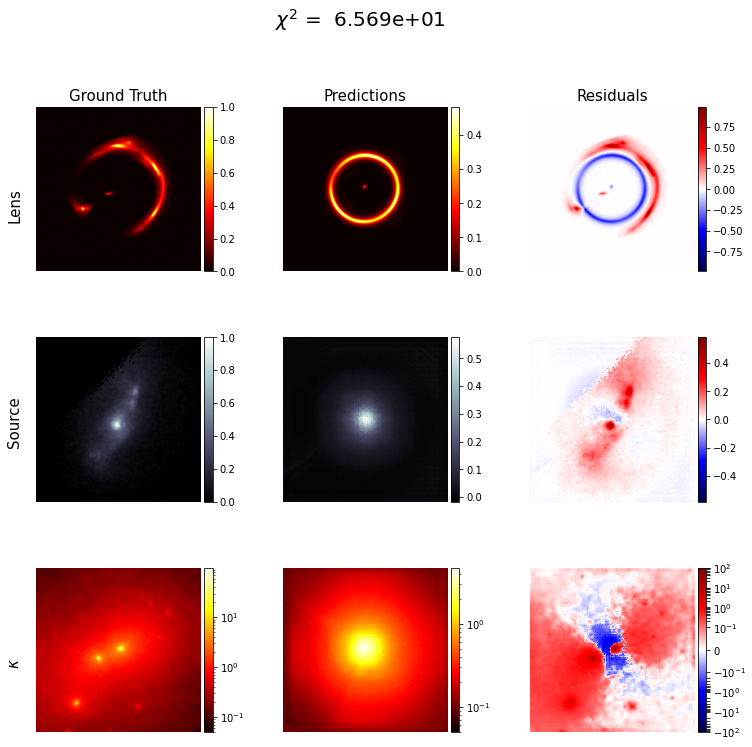

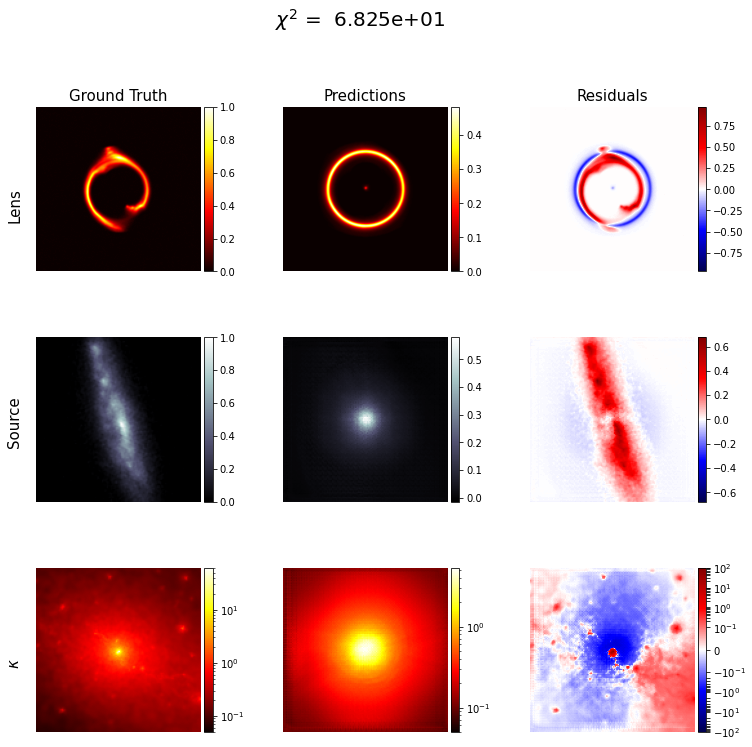

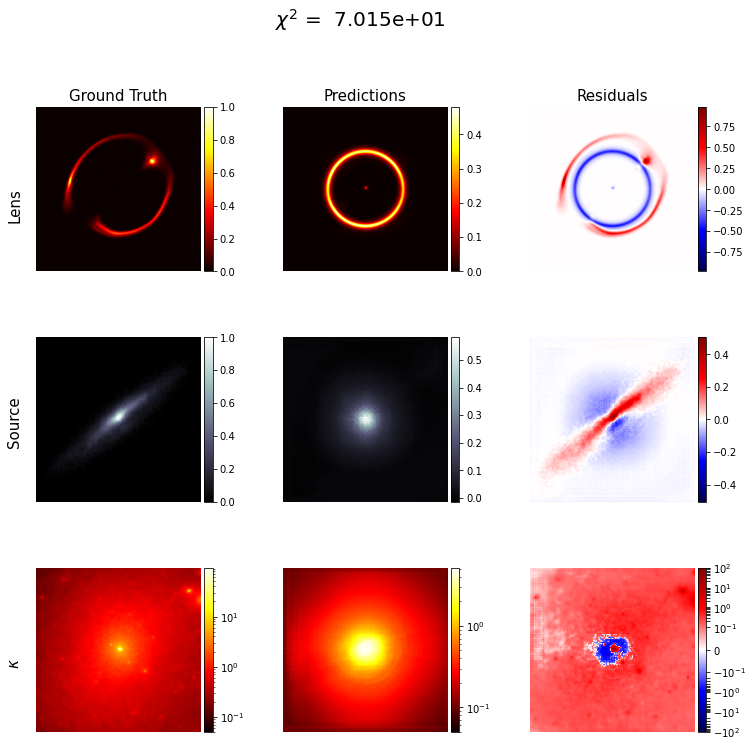

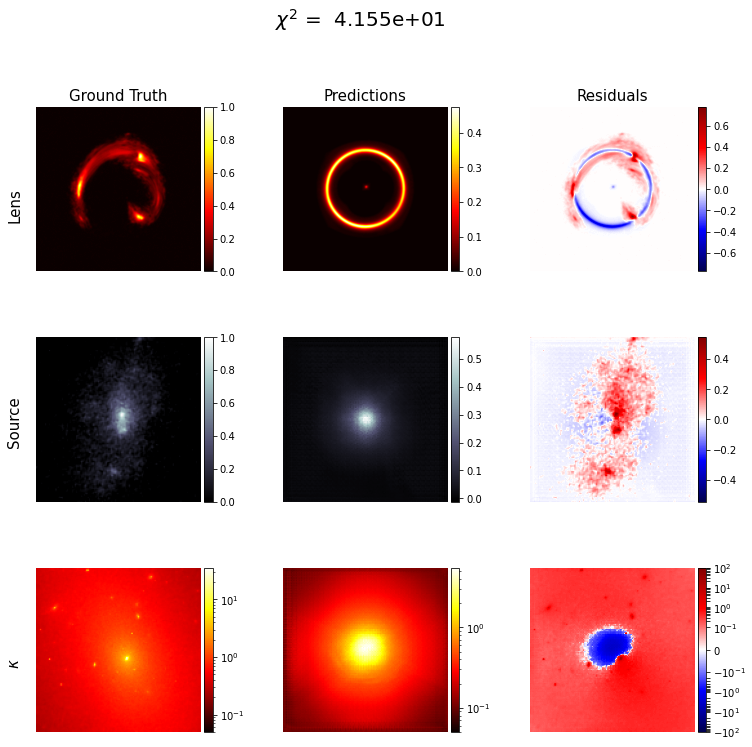

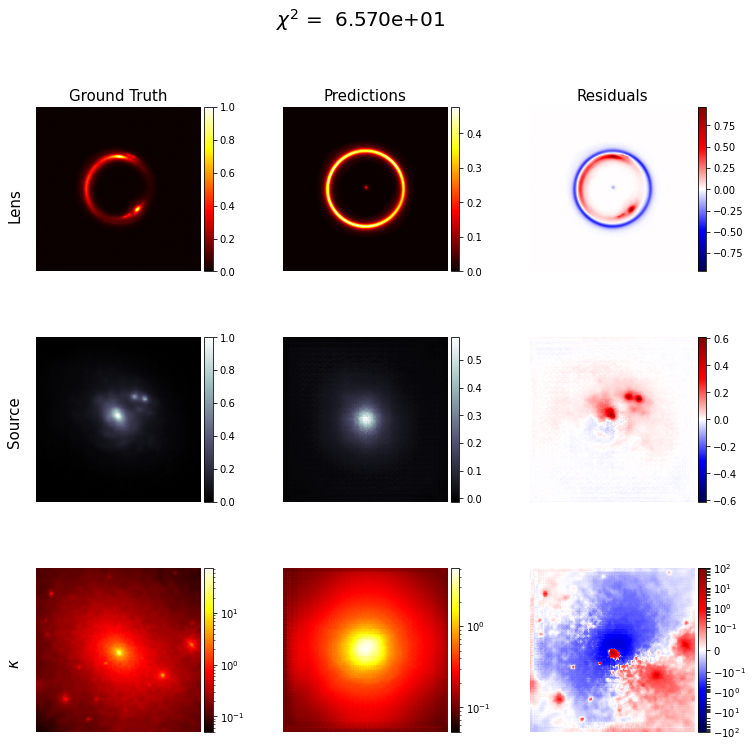

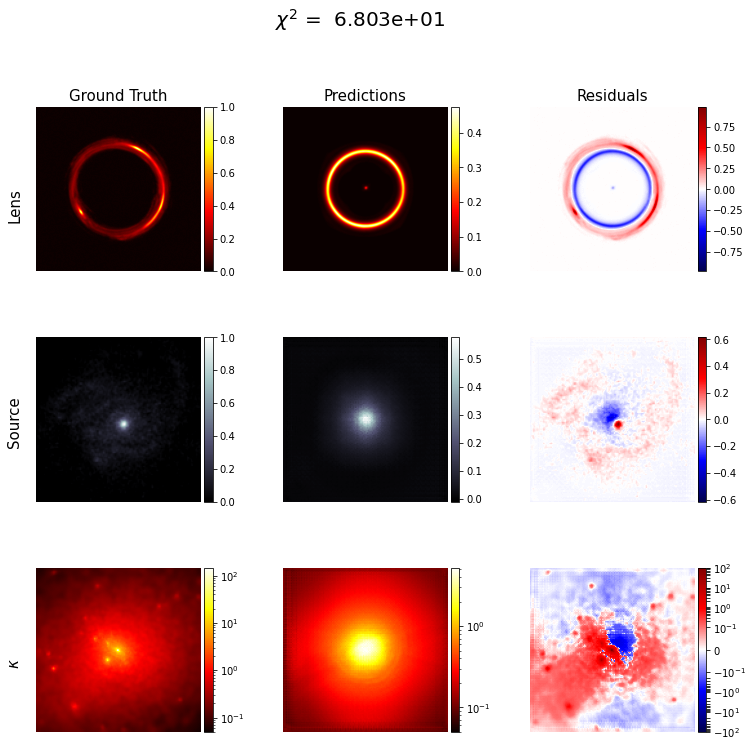

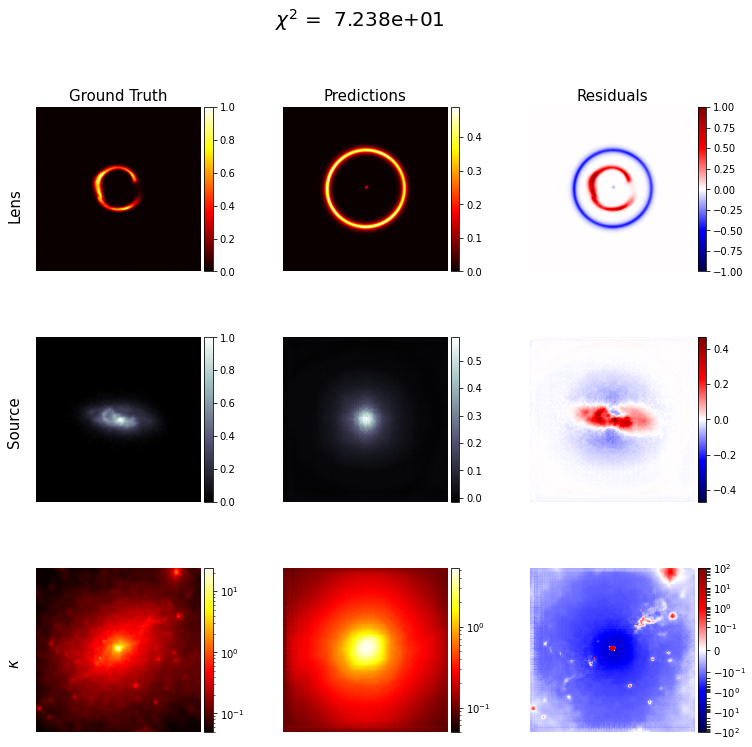

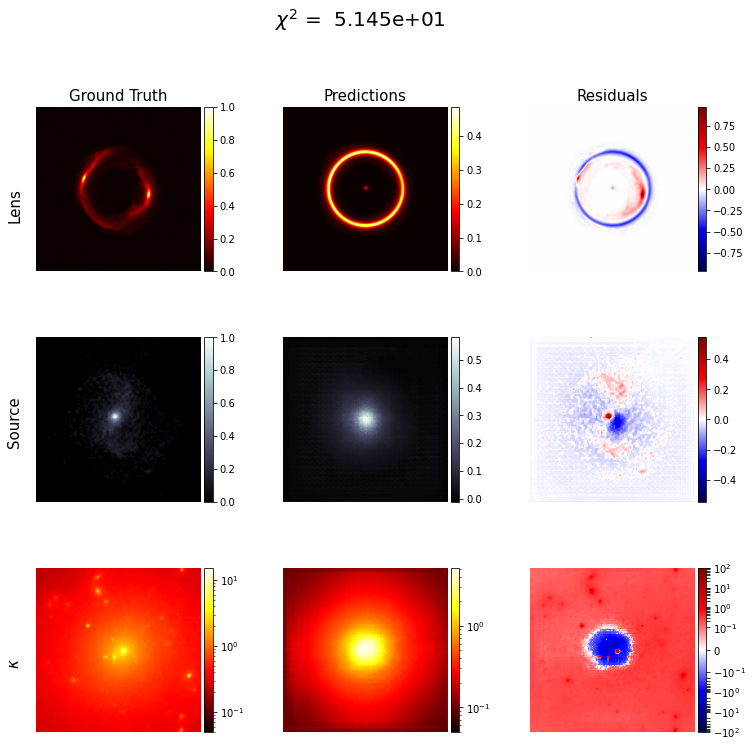

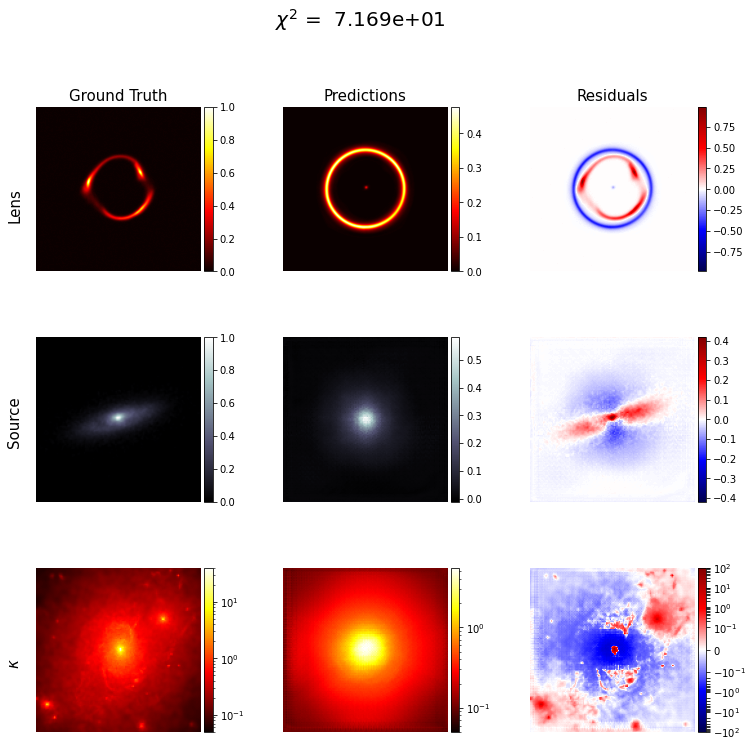

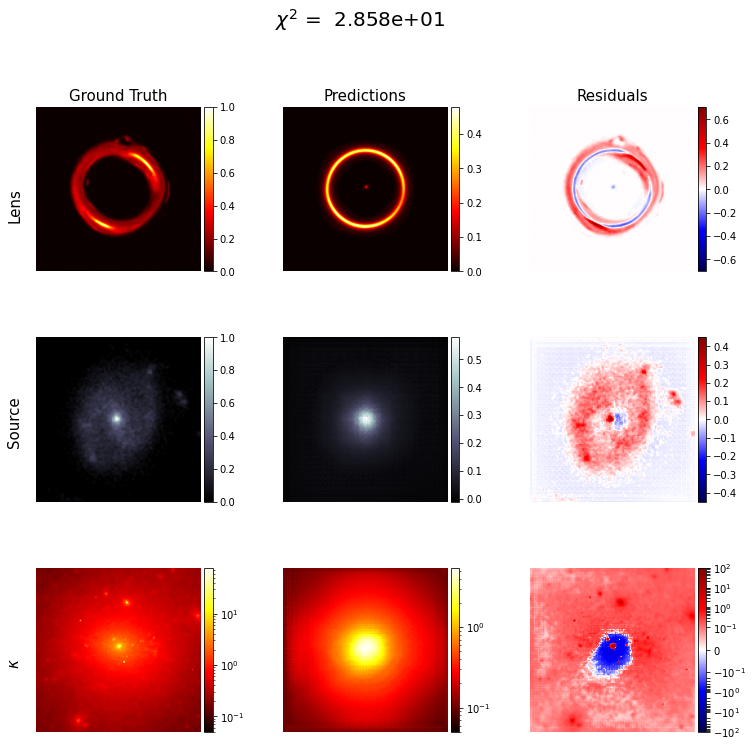

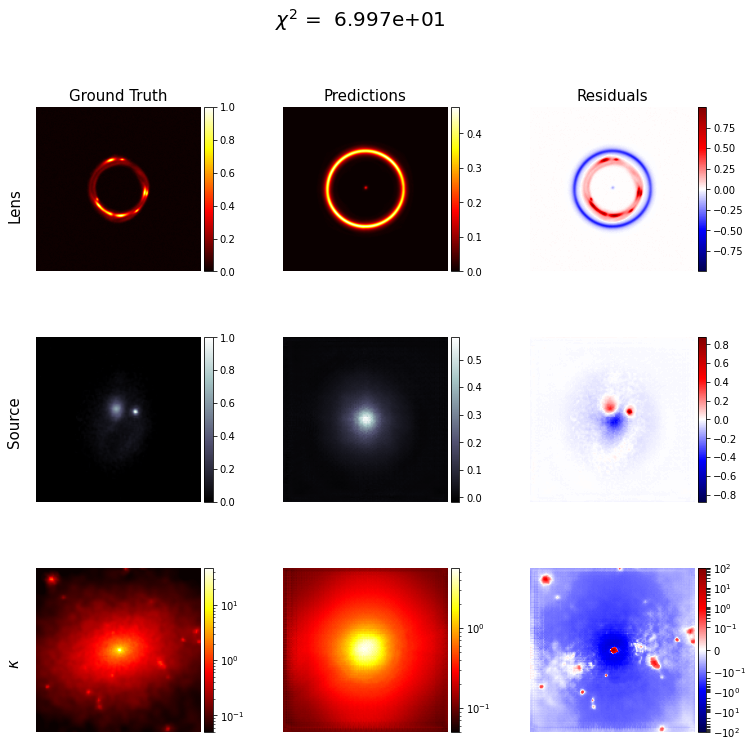

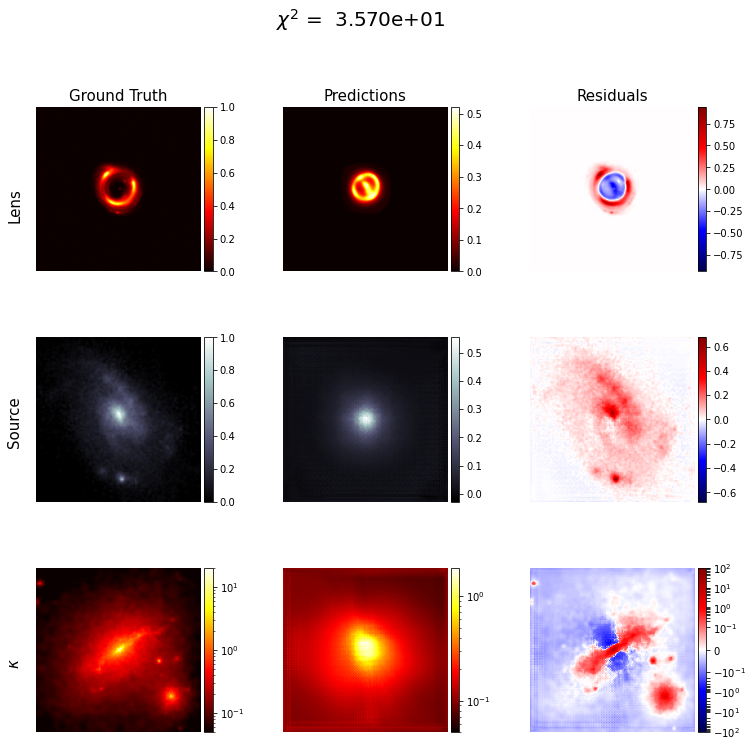

In [7]:
for batch, (X, source, kappa) in enumerate(train_dataset):
    source_pred, kappa_pred, chi_squared = rim.predict(X)
    lens_pred = tf.nn.relu(phys.forward(source_pred[-1], kappa_pred[-1]))
#     lam = tf.reduce_sum(X * lens_pred, axis=(1, 2, 3), keepdims=True) / tf.reduce_sum(X**2, axis=(1, 2, 3), keepdims=True)
    for res_idx in range(args.batch_size):
        residual_plot(
#             lam[res_idx]*X[res_idx], 
            X[res_idx], 
            source[res_idx], 
            kappa[res_idx], 
            lens_pred[res_idx],
            source_pred[-1][res_idx], 
            kappa_pred[-1][res_idx], 
            chi_squared[-1][res_idx])
    if batch == 5:
        break